2023-05-19 13:10:40.652881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 13:10:41.583432: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-05-19 13:10:41.583511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

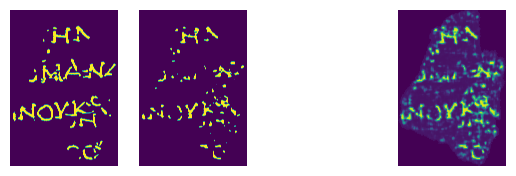

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from train import find_threshold_percentile, fbeta_score, EXP_ID
import PIL.Image as Image
import cv2 

fold = 2
logdir = "resnetrs50_split3d5x7csn_mixup_ep25"
true = np.array(
    Image.open(
        f"../../input/vesuvius-challenge-ink-detection-5fold/train/{str(fold + 1)}/inklabels.png"
    ).convert("1")
)
pred = np.load(f"../../logs/exp{EXP_ID}/{logdir}/fold{fold}/preds_tta.npy")
# pred_pp = np.load(f"../../logs/exp{EXP_ID}/{logdir}/fold{fold}/preds_pp.npy")
logit = np.load(f"../../logs/exp{EXP_ID}/{logdir}/fold{fold}/logits_tta.npy")
plt.subplot(141)
plt.axis("off")
plt.imshow(true)
plt.subplot(142)
plt.axis("off")
plt.imshow(pred)
# plt.subplot(143)
# plt.axis("off")
# plt.imshow(pred_pp)
plt.subplot(144)
plt.axis("off")
plt.imshow(logit, vmin=0., vmax=1.0)
# fbeta_score(true, pred, use_mask=np.ones_like(pred))

score: 0.6824826802609627, threshold: 0.896777343750001(0.5874897536938111)


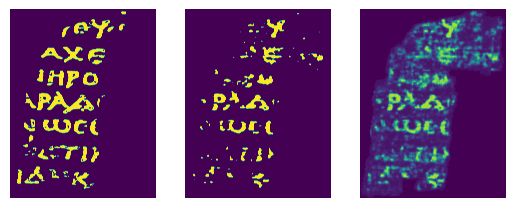

In [3]:
def delete_min_area(y_pred: np.ndarray, t: float):
    num_component, component = cv2.connectedComponents(y_pred.astype(np.uint8))
    size_list = np.array([(c == component) for c in range(1, num_component)])
    size_sum = size_list.sum((1, 2))
    min_size = np.quantile(size_sum, np.clip(t, 0, 1))
    y_pred = size_list[size_sum > min_size].sum(0)
    return y_pred, min_size

fold = 0
logdirs = [
    "resnetrs50_split3d5x7csn_mixup_ep30", 
    "resnetrs50_split3d3x9csn_l6_mixup_ep30",
    "convnext_tiny_split3d5x7csn_mixup_ep30",
    "convnext_tiny_split3d3x9csn_l6_mixup_ep30",
    "swinv2_tiny_window8_256_split3d5x7csn_mixup_ep30",
    "swinv2_tiny_window8_256_split3d3x9csn_l6_mixup_ep30"
    ]
true = np.array(
    Image.open(
        f"../../input/vesuvius-challenge-ink-detection-5fold/train/{str(fold + 1)}/inklabels.png"
    ).convert("1")
)
mask = np.array(
    Image.open(
        f"../../input/vesuvius-challenge-ink-detection-5fold/train/{str(fold + 1)}/mask.png"
    ).convert("1")
) > 0
logit = np.stack([np.load(f"../../logs/exp{EXP_ID}/{logdir}/fold{fold}/logits_tta.npy") for logdir in logdirs]).mean(0)
logit_tmp = logit.reshape(-1)[np.where(mask.reshape(-1))]
true_tmp = true.reshape(-1)[np.where(mask.reshape(-1))]
threshold = find_threshold_percentile(true_tmp, logit_tmp)
# threshold = 0.92
pred = logit > np.quantile(logit_tmp, threshold)
# pred, _ = delete_min_area(pred, 0.2)
score = fbeta_score(true, pred, beta=0.5) 
plt.subplot(131)
plt.axis("off")
plt.imshow(true)
plt.subplot(132)
plt.axis("off")
plt.imshow(pred)
plt.subplot(133)
plt.axis("off")
plt.imshow(logit, vmin=0., vmax=1.0)
print(f"score: {score}, threshold: {threshold}({np.quantile(logit_tmp, threshold)})")

In [ ]:
from train import PatchDataset
from glob import glob
fragment_id = 1
valid_volume_paths = np.asarray(
    sorted(
        glob(
            f"../../input/vesuvius_patches_32_5fold/train/{fragment_id}/surface_volume/**/*.npy",
            recursive=True,
        )
    )
)
